In [1]:
import scanpy as sc
from tidyverse.dummy import *
import sys
from sctools.scplotting import recolor
import gc
import pertpy as pt

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')
from sctools.composition import compositional_pca, plot_pca_loadings
plt.rcParams["figure.figsize"] = (4,3)

from prop_utils import annotate_qval_to_scCODA_result, renamer

import sys
sys.path.append('..')
from util import load_celltype
from colormaps import color_dict_diagnosis, cmap_subtypes

Importing tidyverse


In [2]:
mkdir /tmp/proportions

mkdir: cannot create directory ‘/tmp/proportions’: File exists


In [3]:
plotfolder = '/tmp/proportions/Bcell_proportions/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# SCCODA

In [4]:
A = load_celltype('Bcells')

In [5]:
A.obs.percent_mito.max()

0.09982714

In [6]:
diagnosis_ordered = ['NE', 'M','D','T', 'NS']
cluster_order = ['2', '0','1','3','4','5','6','7','8']

In [8]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    A,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier="leiden",
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

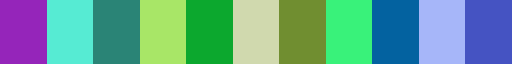

In [9]:
# reorder a little,
from matplotlib.colors import ListedColormap
_cm_colors= cmap_subtypes.colors + ['lightgrey']
_cm_colors = np.array(_cm_colors)[[11,
                                   0,1,2,3,4,5,6,7,8,9
                                  ]]
cmap_subtypes = ListedColormap(
    _cm_colors
)
cmap_subtypes

In [10]:
leiden_color_dict = dict(zip(cluster_order, cmap_subtypes.colors ))
_tmp = [leiden_color_dict[c] for c in A.obs.leiden.cat.categories]

if not 'leiden_colors_backup' in A.uns:
    A.uns['leiden_colors_backup']= A.uns['leiden_colors']
A.uns['leiden_colors'] = _tmp

## Proportions

/tmp/ipykernel_149069/3214155661.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


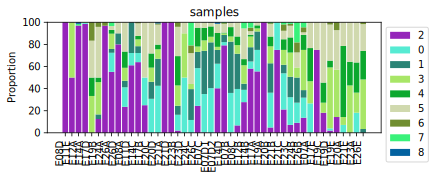

In [11]:
order = []
samplenames = A.obs.samplename.astype(str).unique().tolist()
for d in diagnosis_ordered:
    order.extend(sorted(data_scanpy_1.obs.loc[samplenames].query('diagnosis==@d').index))
    
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,2), show=False, palette=cmap_subtypes,
    level_order=order
)
plt.xticks(rotation=90);
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_sample.svg')

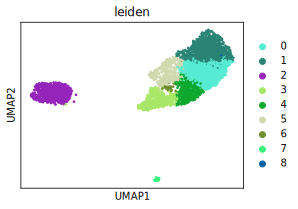

In [12]:
sc.pl.umap(A, color='leiden')

# CODA-PCA

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 1491.56it/s]


<Axes: xlabel='leiden'>

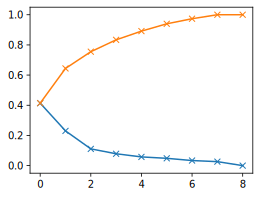

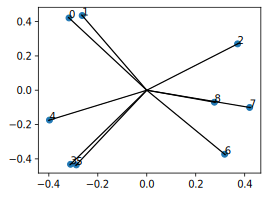

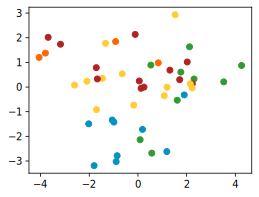

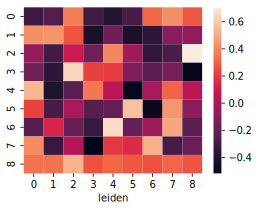

In [13]:
pca, scaler, x_pca_posterior, principal_components_df = compositional_pca(data_scanpy_1)
plt.plot(pca.explained_variance_ratio_, 'x-')
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'x-')

# plot_pca_with_uncertainty()
plt.figure()
plot_pca_loadings(principal_components_df)

plt.figure()
plt.scatter(x_pca_posterior[:,0], x_pca_posterior[:,1], c=[color_dict_diagnosis[_] for _ in data_scanpy_1.obs.diagnosis])

plt.figure()
sns.heatmap(principal_components_df)

## Barplots

In [14]:
set_matplotlib_formats('png')

/tmp/ipykernel_149069/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


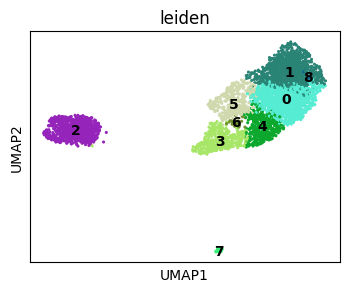

In [15]:
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20, show=False)
plt.savefig(f'{plotfolder}/Bcell_umap.svg')
plt.savefig(f'{plotfolder}/Bcell_umap.png')

/tmp/ipykernel_149069/165465936.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/tmp/ipykernel_149069/165465936.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


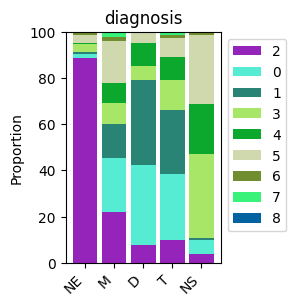

In [16]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_scanpy_1[:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False, palette=cmap_subtypes
)
fig.figure.savefig(f'{plotfolder}/Bcell_proportions_per_diagnosis.svg')
set_matplotlib_formats('png')

In [18]:
set_matplotlib_formats('png')

/tmp/ipykernel_4116628/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 2 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Bcell_proportions//proportions_per_diagnosis_ncells.svg


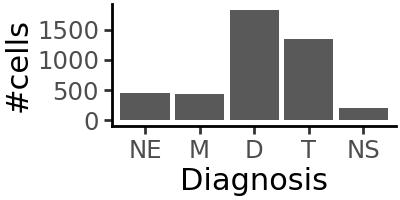

In [17]:
p = (
    pn.ggplot(pd.DataFrame({'n_cells': data_scanpy_1.obs.groupby('diagnosis').n_cells.sum()}).reset_index())
    + pn.aes(x='diagnosis', y='n_cells') 
    + pn.geom_bar(stat='identity')
    + pn.theme_classic() 
    + pn.theme(figure_size=(2,1)) 
    + pn.labs(x='Diagnosis', y='#cells')
)
p.save(f'{plotfolder}/proportions_per_diagnosis_ncells.svg')
p

In [18]:
q = pd.crosstab(
    pd.Series(pd.Categorical(A.obs.leiden, categories=cluster_order), name='leiden', index=A.obs.leiden.index),
    A.obs.diagnosis
)
norm_freqs = q.div( q.sum(1), axis=0)
norm_freqs = norm_freqs.unstack().reset_index().rename({0:'frequency'}, axis=1)
norm_freqs.diagnosis = pd.Categorical(norm_freqs.diagnosis, categories=diagnosis_ordered)

/tmp/ipykernel_149069/495179235.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Bcell_proportions//Bcell_proportions_per_cluster.svg


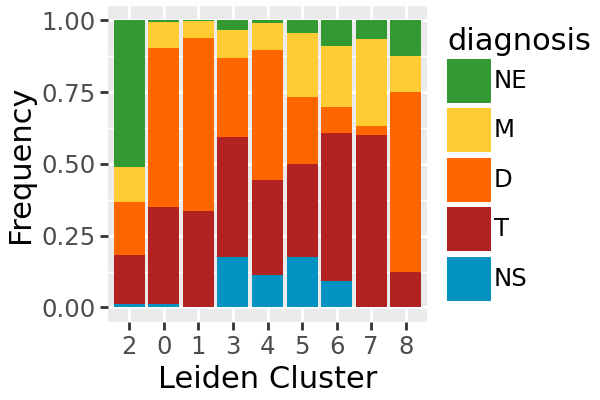

In [19]:
set_matplotlib_formats('svg')
p=pn.ggplot(
    norm_freqs,
    pn.aes(x='leiden', y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(3,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.labs(x='Leiden Cluster', y='Frequency')

p.save(f'{plotfolder}/Bcell_proportions_per_cluster.svg')
p

In [20]:
set_matplotlib_formats('png')

/tmp/ipykernel_149069/2623958728.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


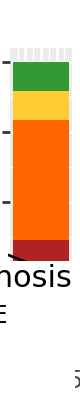

In [21]:
overall_props = A.obs.diagnosis.value_counts()
overall_props = overall_props/overall_props.sum()
overall_props = overall_props.loc[diagnosis_ordered]

_ddd = pd.DataFrame(overall_props).reset_index().rename({'count': 'frequency'}, axis=1)
_ddd.diagnosis = pd.Categorical(_ddd.diagnosis, categories=diagnosis_ordered)

pn.ggplot(
    _ddd,
    pn.aes(x=1, y='frequency', fill='diagnosis')) + pn.geom_bar(stat='identity') \
+ pn.theme(figure_size=(7,2)) + pn.scale_fill_manual(color_dict_diagnosis) + pn.theme(figure_size=(0.4,2)) + pn.labs(x='', y='Frequency')

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 3 x 1 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/proportions/Bcell_proportions//proportions_per_cluster_ncells.svg


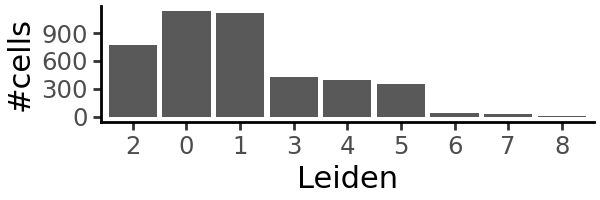

In [22]:
p = pn.ggplot(pd.DataFrame({'n_cells': q.reset_index().melt(id_vars=['leiden']).groupby('leiden').value.sum()}).reset_index(), pn.aes(x='leiden', y='n_cells')) + pn.geom_bar(stat='identity') \
+ pn.theme_classic() + pn.theme(figure_size=(3,1)) + pn.labs(x='Leiden', y='#cells')
p.save(f'{plotfolder}/proportions_per_cluster_ncells.svg')
p

## MCMC

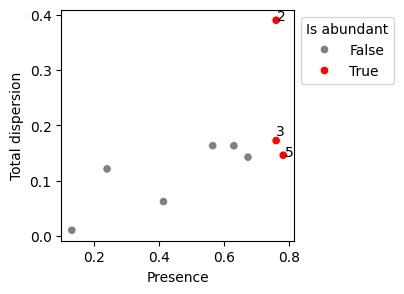

In [23]:
sccoda_model.plot_rel_abundance_dispersion_plot(sccoda_data, figsize=(3,3), abundant_threshold=0.75); plt.show()

### diag + patient + procedure

In [26]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    # formula="TRG",
    formula="C(diagnosis, Treatment('NE')) + patient + procedure",
    reference_cell_type="5",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda")
sccoda_data["coda"]

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11000/11000 [12:28<00:00, 14.69it/s, 511 steps of size 9.22e-03. acc. prob=0.88]


AnnData object with n_obs × n_vars = 46 × 9
    obs: 'samplename', 'patient', 'procedure', 'diagnosis', 'n_cells'
    var: 'n_cells'
    uns: 'scCODA_params'
    obsm: 'covariate_matrix', 'sample_counts'
    varm: 'intercept_df', "effect_df_C(diagnosis, Treatment('NE'))[T.M]", "effect_df_C(diagnosis, Treatment('NE'))[T.D]", "effect_df_C(diagnosis, Treatment('NE'))[T.T]", "effect_df_C(diagnosis, Treatment('NE'))[T.NS]", 'effect_df_patient[T.E08]', 'effect_df_patient[T.E11]', 'effect_df_patient[T.E12]', 'effect_df_patient[T.E14]', 'effect_df_patient[T.E17]', 'effect_df_patient[T.E19]', 'effect_df_patient[T.E20]', 'effect_df_patient[T.E21]', 'effect_df_patient[T.E23]', 'effect_df_patient[T.E24]', 'effect_df_patient[T.E26]', 'effect_df_procedure[T.resection]'

In [27]:
sccoda_model.set_fdr(sccoda_data, est_fdr=0.05)
scCODA_result = sccoda_model.get_effect_df(sccoda_data)
scCODA_result['pvalue'] = 1-scCODA_result['Inclusion probability']
scCODA_result['log10pvalue'] = np.log10(scCODA_result['pvalue'])

scCODA_result = annotate_qval_to_scCODA_result(scCODA_result)

scCODA_result.to_csv(f'{plotfolder}/MCMC_diag_procedure_patient.csv')
scCODA_result[scCODA_result['Final Parameter'] != 0]

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


Final Parameter  HDI 3%  HDI 97%  \
Covariate                         Cell Type                                     
C(diagnosis, Treatment('NE'))T.M  2                -2.145371  -2.870   -1.413   
C(diagnosis, Treatment('NE'))T.D  2                -2.154050  -2.990   -1.310   
C(diagnosis, Treatment('NE'))T.T  1                 0.913341  -0.008    1.682   
                                  2                -1.964229  -2.665   -1.232   
C(diagnosis, Treatment('NE'))T.NS 0                -1.160104  -1.919    0.001   
                                  1                -1.100141  -1.961    0.003   
                                  2                -2.395525  -3.275   -1.467   
patientT.E12                      2                 2.149138   1.138    3.088   
patientT.E14                      2                 3.406678   2.711    4.020   

                                                SD  Inclusion probability  \
Covariate                         Cell Type                                 
C(diagnosis, Treatment('NE'))T.M  2          0.379                 1.0000   
C(diagnosis, Treatment('NE'))T.D  2          0.438                 1.0000   
C(diagnosis, Treatment('NE'))T.T  1          0.526                 0.8502   
                                  2          0.369                 1.0000   
C(diagnosis, Treatment('NE'))T.NS 0          0.586                 0.8915   
                                  1          0.627                 0.8449   
                                  2          0.474                 1.0000   
patientT.E12                      2          0.514                 0.9991   
patientT.E14                      2          0.324                 1.0000   

                                             Expected Sample  \
Covariate                         Cell Type                    
C(diagnosis, Treatment('NE'))T.M  2                 7.329112   
C(diagnosis, Treatment('NE'))T.D  2                 7.270654   
C(diagnosis, Treatment('NE'))T.T  1                25.790072   
                                  2                 7.238546   
C(diagnosis, Treatment('NE'))T.NS 0                 8.444523   
                                  1                 5.587219   
                                  2                 7.630071   
patientT.E12                      2                81.354018   
patientT.E14                      2                90.391271   

                                             log2-fold change  pvalue  \
Covariate                         Cell Type                             
C(diagnosis, Treatment('NE'))T.M  2                 -2.430835  0.0000   
C(diagnosis, Treatment('NE'))T.D  2                 -2.442389  0.0000   
C(diagnosis, Treatment('NE'))T.T  1                  1.702681  0.1498   
                                  2                 -2.448774  0.0000   
C(diagnosis, Treatment('NE'))T.NS 0                 -0.590442  0.1085   
                                  1                 -0.503933  0.1551   
                                  2                 -2.372777  0.0000   
patientT.E12                      2                  1.041668  0.0009   
patientT.E14                      2                  1.193638  0.0000   

                                             log10pvalue  \
Covariate                         Cell Type                
C(diagnosis, Treatment('NE'))T.M  2                 -inf   
C(diagnosis, Treatment('NE'))T.D  2                 -inf   
C(diagnosis, Treatment('NE'))T.T  1            -0.824488   
                                  2                 -inf   
C(diagnosis, Treatment('NE'))T.NS 0            -0.964570   
                                  1            -0.809388   
                                  2                 -inf   
patientT.E12                      2            -3.045757   
patientT.E14                      2                 -inf   

                                             Inclusion_probability_soft  \
Covariate                         Cell Type                 

In [28]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change']* (_q['Final Parameter'] !=0), aggfunc=np.mean).replace({np.nan: 0})

/tmp/ipykernel_4116628/972804642.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


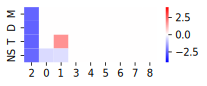

In [29]:
set_matplotlib_formats('svg')

fig, ax = plt.subplots(figsize=(3, 1))
sns.heatmap(a.loc[['M','D','T','NS'], cluster_order], cmap=plt.cm.bwr, vmin=-4, vmax=4)
# plt.title('Log2 fold change (wrt NE)')
plt.xlabel(None)
plt.ylabel(None)
fig.savefig(f'{plotfolder}/matrix_scCODA.svg')

In [30]:
_q = scCODA_result.reset_index()
a = pd.crosstab(_q['Covariate'].replace(renamer),
    _q['Cell Type'], 
    values=_q['log2-fold change'], aggfunc=np.mean).replace({np.nan: 0})
a

Cell Type,0,1,2,3,4,5,6,7,8
Covariate,,,,,,,,,
D,0.665248,0.665248,-2.442389,0.665248,0.665248,0.665248,0.665248,0.665248,0.665248
M,0.664281,0.664281,-2.430835,0.664281,0.664281,0.664281,0.664281,0.664281,0.664281
NS,-0.590442,-0.503933,-2.372777,1.083235,1.083235,1.083235,1.083235,1.083235,1.083235
T,0.385009,1.702681,-2.448774,0.385009,0.385009,0.385009,0.385009,0.385009,0.385009
patientT.E08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
patientT.E12,-2.058883,-2.058883,1.041668,-2.058883,-2.058883,-2.058883,-2.058883,-2.058883,-2.058883
patientT.E14,-3.721160,-3.721160,1.193638,-3.721160,-3.721160,-3.721160,-3.721160,-3.721160,-3.721160
patientT.E17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Marker plots

/tmp/ipykernel_4116628/1555712036.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


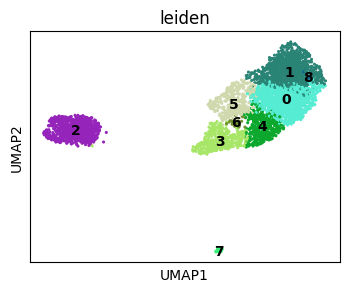

In [31]:
set_matplotlib_formats('png')
sc.pl.umap(A, color=['leiden'], legend_loc='on data', size=20)

/tmp/ipykernel_4116628/2517802186.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


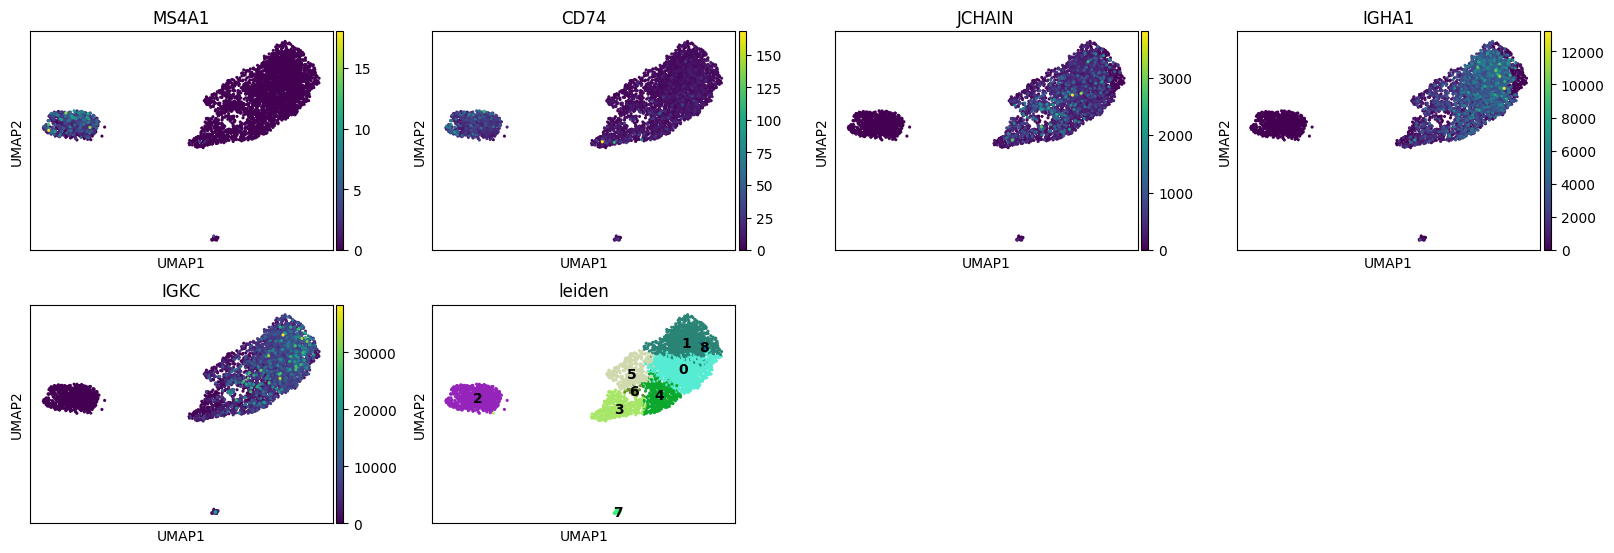

/tmp/ipykernel_4116628/2517802186.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


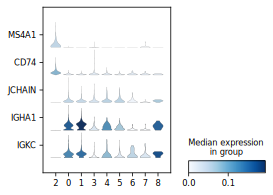

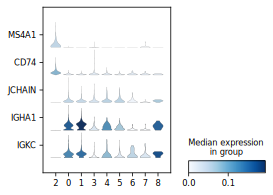

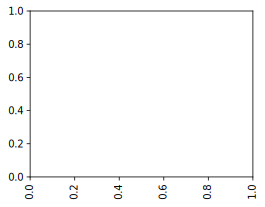

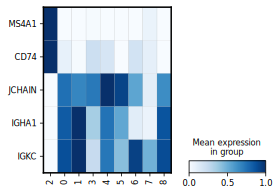

In [32]:
genes =['MS4A1', 'CD74', 'JCHAIN', 'IGHA1','IGKC']
set_matplotlib_formats('png')
sc.pl.umap(A, color=genes+['leiden'], legend_loc='on data', size=20)

B = A.copy()
B.obs['leiden'] = pd.Categorical(B.obs['leiden'], categories=cluster_order)
set_matplotlib_formats('svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True,show=False,  #order=cluster_order
                figsize=(4,3))
plt.savefig(f'{plotfolder}/Bcell_markers.svg')
sc.pl.stacked_violin(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, use_raw=False,  #order=cluster_order
                figsize=(4,3))
plt.xticks(rotation=90);

sc.pl.matrixplot(B, var_names=genes, groupby='leiden', standard_scale='var', swap_axes=True, show=False, #order=cluster_order
                figsize=(4,3), cmap='Blues')
plt.savefig(f'{plotfolder}/Bcell_markers_matrix.svg')